# Color Analysis

In [1]:
from analyze import analyze_color_histogram
from scg_detection_tools.models import YOLO_NAS, YOLOv8
from scg_detection_tools.detect import Detector
from scg_detection_tools.utils.file_handling import read_yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import cv2

cfg = read_yaml("analyze_config.yaml")
#model = YOLOv8(yolov8_ckpt_path=cfg["yolov8_model_path"])
model = YOLO_NAS(model_arch=cfg["yolonas_arch"], 
                 checkpoint_path=cfg["yolonas_model_path"], 
                 classes=cfg["data_classes"])
det_params = cfg["detect_parameters"]
det_params["embed_slice_callback"] = None
det = Detector(detection_model=model, detection_params=det_params)


[2024-09-04 11:20:18] INFO - checkpoint_utils.py - Successfully loaded model weights from /home/julio/Dev/SCG_IFSC/checkpoints/yolonas/large/train2/ckpt_best.pth EMA checkpoint.


In [ ]:
from scg_detection_tools.utils.file_handling import get_all_files_from_paths

IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/images"
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/labels"

IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/images"
imgs = get_all_files_from_paths(IMG_DIR)
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/light_group_annotations/labels"


#IMG_DIR = "/home/julio/Dev/SCG_IFSC/save/hemacias"
#imgs = get_all_files_from_paths(IMG_DIR)


img_hists = analyze_color_histogram(model=model, detector=det, imgs=imgs, raw=False, on_detection_boxes=False, seg_annotations=LBL_DIR, cspaces=["RGB", "HSV", "GRAY"], show=True, save_plots=False)


In [ ]:
import os
for img in imgs:
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,8))
    
    rgb = cv2.imread(img)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(rgb.copy(), cv2.COLOR_RGB2HSV)

    for ci, cp in enumerate([rgb, hsv]):
        for i in range(3):
            ch = cp.copy()
            for j in range(3):
                if i != j:
                    ch[:,:,j] = 0
            axs[ci][i].axis("off")
            axs[ci][i].imshow(ch)
    fig.savefig(f"exp_analysis/singlechannel_{os.path.basename(img)}")
    plt.show()

In [ ]:
cspaceAnalysis = {"RGB": [], "HSV": [], "GRAY": [], "ALL": []}
nclass = {0: "light", 1: "medium", 2: "dark", 3: "dead"}
intensities = np.arange(256)

for img in img_hists:
    img_hist = img_hists[img]
    for cspace in ["RGB", "HSV", "GRAY"]:
        for mask_hist in img_hist[cspace]["masks"]:
            hist = mask_hist["hist"]
            mask_class = nclass[mask_hist["class"]]

            ch_stats = []
            for ch_hist in hist:
                ch_mean = np.sum(intensities * ch_hist) / np.sum(ch_hist)
                ch_std = np.sqrt(np.sum((intensities - ch_mean) ** 2 * ch_hist) / np.sum(ch_hist))
                ch_stats.append([ch_mean, ch_std])
            
            ch_stats = np.array(ch_stats).T.ravel().tolist()
            ch_stats.append(mask_class)
            cspaceAnalysis[cspace].append(ch_stats)


num_masks = len(cspaceAnalysis["RGB"])
all_mean = []
all_std = []
all_class = [data[-1] for data in cspaceAnalysis["RGB"]]

for maskidx in range(num_masks):
    all_mean.append([])
    all_std.append([])
    for cspace in ["RGB", "HSV", "GRAY"]:
        data = cspaceAnalysis[cspace][maskidx]
        if cspace == "GRAY":
            ch_mean = data[0]
            ch_std = data[1]
            all_mean[-1].append(ch_mean)
            all_std[-1].append(ch_std)
        else:
            ch_mean = data[:3]
            ch_std = data[3:-1]
            all_mean[-1].extend(ch_mean)
            all_std[-1].extend(ch_std)
for i in range(num_masks):
    cspaceAnalysis["ALL"].append([])
    
    cspaceAnalysis["ALL"][i].extend(all_mean[i])
    cspaceAnalysis["ALL"][i].extend(all_std[i])
    cspaceAnalysis["ALL"][i].append(all_class[i])

rgbdf = pd.DataFrame(cspaceAnalysis["RGB"], columns=[
    "R Mean", "G Mean", "B Mean", "R std", "G std", "B std", "Class"
])
hsvdf = pd.DataFrame(cspaceAnalysis["HSV"], columns=[
    "H Mean", "S Mean", "V Mean", "H std", "S std", "V std", "Class"
])
graydf = pd.DataFrame(cspaceAnalysis["GRAY"], columns=[
    "Gray mean", "Gray std", "Class"
])

alldf = pd.DataFrame(cspaceAnalysis["ALL"], columns=[
    "R Mean", "G Mean", "B Mean", "H Mean", "S Mean", "V Mean", "Gray mean", "R std", "G std", "B std", "H std", "S std", "V std", "Gray std", "Class"
])

class_color = lambda df: df["Class"].map({
    "light": "b", 
    "medium": "g", 
    "dark": "r", 
    "dead": "k"
})

scatter_matrix(rgbdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(rgbdf))
scatter_matrix(hsvdf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(hsvdf))
scatter_matrix(graydf.iloc[:,:-1], figsize=(12,12), diagonal="kde", c=class_color(graydf))
scatter_matrix(alldf.iloc[:,:-1], figsize=(20,20), diagonal="kde", c=class_color(alldf))

print(rgbdf.corr(numeric_only=True))
print(hsvdf.corr(numeric_only=True))
print(graydf.corr(numeric_only=True))

In [ ]:
print(len(img_hists[imgs[0]]["RGB"]["masks"]))

# Pixel density

['/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/0.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/1.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/2.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/3.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/4.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/5.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/6.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/7.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/8.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/9.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/10.png', '/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/11.png']


[2024-09-04 11:23:24] INFO - build_sam.py - Loaded checkpoint sucessfully


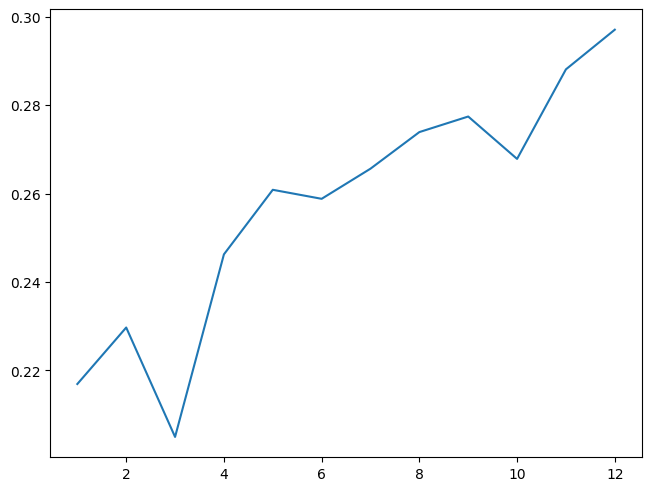

Calculated pixel density for each image: [('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/0.png', 0.21691831707656328), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/1.png', 0.2296941022907585), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/2.png', 0.20495111253224535), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/3.png', 0.2462421882248466), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/4.png', 0.2608416908347444), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/5.png', 0.2588018858189511), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/6.png', 0.26561881681056637), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/7.png', 0.2738931201144612), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/8.png', 0.2774123671734879), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/9.png', 0.2678277763726982), ('/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis/10.png', 0.28808299427365885), ('/home/julio/Dev/

In [6]:
from analyze import analyze_pixel_density
from scg_detection_tools.utils.file_handling import get_all_files_from_paths
from pathlib import Path

IMG_DIR = "/home/julio/Dev/SCG_IFSC/scg-leaf-count/imgs/analysis"
LBL_DIR = "/home/julio/Dev/SCG_IFSC/save/first_analysis_detections/out_cache/"

imgs = get_all_files_from_paths(IMG_DIR)

def sort_stem(item):
    s = Path(item).stem
    try:
        val = int(s)
        return val
    except:
        return s

imgs = sorted(imgs, key=sort_stem)
print(imgs)

densities = analyze_pixel_density(model=model, 
                                  detector=det, 
                                  imgs=imgs, 
                                  cfg=cfg, 
                                  on_slice=False, 
                                  on_detection_boxes=True,
                                  on_crops=False,
                                  cached_det_boxes=LBL_DIR,
                                  seg_annotations=None, 
                                  save_detections=False)
print(densities)